In [6]:
import pandas as pd

# Load the data
population = pd.read_csv("Population.csv")

# Clean column names: lowercase, replace hyphens with underscores
population.columns = (
    population.columns
    .str.lower()
    .str.replace("-", "_")
    .str.replace(" ", "_")
)

# Show cleaned columns
print("Cleaned columns:", population.columns.tolist())

# Confirm data types and nulls (should be fine)
print(population.info())
print(population.isnull().sum())

# Optional: Save cleaned version for PostgreSQL import
population.to_csv("p_cleaned.csv", index=False)


Cleaned columns: ['sa2_code', 'sa2_name', '0_4_people', '5_9_people', '10_14_people', '15_19_people', '20_24_people', '25_29_people', '30_34_people', '35_39_people', '40_44_people', '45_49_people', '50_54_people', '55_59_people', '60_64_people', '65_69_people', '70_74_people', '75_79_people', '80_84_people', '85_and_over_people', 'total_people']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            373 non-null    int64 
 1   sa2_name            373 non-null    object
 2   0_4_people          373 non-null    int64 
 3   5_9_people          373 non-null    int64 
 4   10_14_people        373 non-null    int64 
 5   15_19_people        373 non-null    int64 
 6   20_24_people        373 non-null    int64 
 7   25_29_people        373 non-null    int64 
 8   30_34_people        373 non-null    int64 
 9   35_39_people  

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

In [9]:
# This loads the POIs from the REST service directly
poi_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query?where=1%3D1&outFields=*&f=geojson"

pois = gpd.read_file(poi_url)
print(pois.columns)
pois.head()

Index(['objectid', 'topoid', 'poigroup', 'poitype', 'poiname', 'poilabel',
       'poilabeltype', 'poialtlabel', 'poisourcefeatureoid', 'accesscontrol',
       'startdate', 'enddate', 'lastupdate', 'msoid', 'centroidid',
       'shapeuuid', 'changetype', 'processstate', 'urbanity', 'geometry'],
      dtype='object')


,objectid,topoid,poigroup,poitype,poiname,poilabel,poilabeltype,poialtlabel,poisourcefeatureoid,accesscontrol,startdate,enddate,lastupdate,msoid,centroidid,shapeuuid,changetype,processstate,urbanity,geometry
0,1,500000000,9,Mine - Underground,None,Mine - Underground,GENERIC,None,157,1,1628668563000,32503680000000,1628668617000,233046,None,729e2b57-0cd4-3f70-90fa-9dce09e34a8e,I,None,S,POINT (152.12202 -31.10616)
1,2,500005504,3,Lookout,KUNDERANG LOOKOUT,KUNDERANG LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83091,None,d88a28a8-c572-3992-995f-d26a274aea18,I,None,S,POINT (152.29869 -31.02148)
2,3,500005505,3,Lookout,FALLS LOOKOUT,FALLS LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83691,None,21b476d2-6519-3e28-8b19-1526fcb9652f,I,None,S,POINT (152.33786 -31.01576)
3,4,500005507,3,Lookout,MCCOYS LOOKOUT,MCCOYS LOOKOUT,NAMED,None,56,1,1285588392000,32503680000000,1285588392535,83380,None,016d69b2-6530-39e7-89a6-6e3054df55ac,I,None,S,POINT (152.34181 -31.01897)
4,5,500012781,3,Picnic Area,WILSON RIVER PICNIC AREA,WILSON RIVER PICNIC AREA,NAMED,None,62,1,1608714678000,32503680000000,1608714706360,231054,None,49ad26c8-609e-3aa0-b4ad-51459b43ab51,M,None,S,POINT (152.47882 -31.20754)


In [13]:
# Load stops.txt
stops = pd.read_csv('Stops.txt')

# Preview
stops.head()

# Some cleaning
# Drop rows where stop_lat or stop_lon is missing
stops = stops.dropna(subset=['stop_lat', 'stop_lon'])

# We want to only select the stops inside three areas: 
# Inner West, North Sydney and Hornsby, City and Inner South

# No column name telling which region a stop belongs to
# So: use the stop's latitude and longitude (stop_lat, stop_lon) to filter our disired data

In [15]:
sa2 = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

print(sa2.columns)
sa2.head()

sa2_sydney = sa2[sa2['GCC_NAME21'] == 'Greater Sydney']

# Create geometry column for stops
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

# Turn stops into a GeoDataFrame (same CRS)
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry', crs="EPSG:4283")

stops_gdf = stops_gdf.to_crs(epsg=7844)

stops_with_sa2 = gpd.sjoin(stops_gdf, sa2_sydney, how='left', predicate='within')

# print(stops_with_sa2.head(10)) #debug

target_regions = [
    'Sydney - Inner West',
    'Sydney - North Sydney and Hornsby',
    'Sydney - City and Inner South'
]

filtered_stops = stops_with_sa2[stops_with_sa2['SA4_NAME21'].isin(target_regions)]

filtered_stops = filtered_stops.dropna(subset=['SA4_NAME21'])

columns_to_keep = [
    'stop_id', 'stop_name', 'stop_lat', 'stop_lon',
    'wheelchair_boarding', 'SA2_CODE21', 'SA2_NAME21', 'SA4_NAME21', 'geometry'
]

filtered_stops = filtered_stops[columns_to_keep]

filtered_stops.columns = filtered_stops.columns.str.lower()

filtered_stops.to_csv('s_filtered.csv', index=False)


Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry'],
      dtype='object')


In [16]:
# Adjust path as needed
catchments_primary = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/catchments/catchments_primary.shp")

# Preview structure
print(catchments_primary.columns)
catchments_primary.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.7296, 150.92602 -33.72..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [17]:
# Adjust path as needed
catchments_secondary = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/catchments/catchments_secondary.shp")

# Preview structure
print(catchments_secondary.columns)
catchments_secondary.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.6893 -35.31..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.8125 -35.79..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.686 -33.74031, 150.68631 -..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [18]:
# Adjust path as needed
catchments_future = gpd.read_file("~/Desktop/DATA2001/DATA2001-A/catchments/catchments_future.shp")

# Preview structure
print(catchments_future.columns)
catchments_future.head()

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'geometry'],
      dtype='object')


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.5399, 151.19945 -33.54..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.6982, 151.17859 -33.69..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [20]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd

credentials = os.path.expanduser("~/Desktop/DATA2001/Tutorial/Credentials.json")


def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = "assignment"  ##### The right database
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [25]:
db, conn = pgconnect(credentials)

Connected successfully.


In [ ]:
import geopandas as gpd

# Define shapefile paths
base_path = "~/Desktop/DATA2001/DATA2001-A/catchments/"
shapefiles = {
    "catchments_primary": "catchments_primary.shp",
    "catchments_secondary": "catchments_secondary.shp",
    "catchments_future": "catchments_future.shp"
}

# Loop through the catchment files and upload to PGadmin
for table_name, shp_file in shapefiles.items():
    print(f"Processing {table_name}...")
    gdf = gpd.read_file(os.path.expanduser(os.path.join(base_path, shp_file)))
    gdf.columns = [col.lower() for col in gdf.columns]  
    gdf.to_postgis(name=table_name, con=db, if_exists="replace", index=False)
    print(f"Uploaded {table_name} successfully.")

print(f"Using DB: {db.url.database}")

Processing catchments_primary...


In [ ]:
sa2_path = "~/Desktop/DATA2001/DATA2001-A/SA2_regions/SA2_2021_AUST_GDA2020.shp"
sa2_gdf = gpd.read_file(os.path.expanduser(sa2_path))

#Keep only useful columns
sa2_gdf.columns = [col.lower() for col in sa2_gdf.columns]
columns_to_keep = ["sa2_code21", "sa2_name21", "sa4_name21", "geometry"]
sa2_gdf = sa2_gdf[columns_to_keep]

# Filter rows by target SA4 regions
target_sa4 = [
    "Sydney - Inner West",
    "Sydney - North Sydney and Hornsby",
    "Sydney - City and Inner South"
]
sa2_gdf = sa2_gdf[sa2_gdf["sa4_name21"].isin(target_sa4)]

# SUpload to PostgreSQL
sa2_gdf.to_postgis(name="sa2_regions", con=db, if_exists="replace", index=False)

print(f"✅ Cleaned and uploaded 'sa2_regions' with {len(sa2_gdf)} rows.")
sa2_gdf.head()

## TASK 2 - INNER WEST

In [ ]:
innerwest_gdf = gpd.read_postgis("""
    SELECT *
    FROM sa2_regions
    WHERE sa4_name21 = 'Sydney - Inner West'
""", conn, geom_col="geometry")

In [ ]:
import requests
import io
import geopandas as gpd

def get_pois_from_bbox(minx, miny, maxx, maxy):
    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
    params = {
        "f": "geojson",
        "geometryType": "esriGeometryEnvelope",
        "geometry": f"{minx},{miny},{maxx},{maxy}",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "inSR": "4283",
        "outSR": "4283"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return gpd.read_file(io.StringIO(response.text))
    except Exception as e:
        print(f"❌ Error fetching POIs for bbox {minx},{miny},{maxx},{maxy}:", e)
        return None


In [ ]:
import time
from shapely.geometry import shape

all_pois = []

for _, row in innerwest_gdf.iterrows():
    sa2 = row["sa2_name21"]
    minx, miny, maxx, maxy = row["geometry"].bounds
    print(f"📦 Fetching POIs for {sa2}...")
    
    pois = get_pois_from_bbox(minx, miny, maxx, maxy)
    if pois is not None and not pois.empty:
        pois["sa2_name"] = sa2
        all_pois.append(pois)
    
    time.sleep(1)  # be nice to the server


In [ ]:
from geopandas import GeoDataFrame

if all_pois:
    all_pois_gdf = gpd.GeoDataFrame(pd.concat(all_pois, ignore_index=True), crs="EPSG:4283")
    all_pois_gdf.to_postgis("pois_innerwest", con=db, if_exists="replace", index=False)
    print(f"✅ Uploaded {len(all_pois_gdf)} POIs.")
else:
    print("⚠️ No POIs collected.")

### Task 3 Spec : WEEK 10 Tutorial
creat z scores for every SA4 , and every SA2 in SA4

calculate z scores for each aspect, and substitute the sum into the sigmoid function 

for every zone, find mean, sd, conpute z score

for means, can do mean of the entire dataset, or mean of specified SA4 (better, recommended)

Conpute the z scores for stops, businesses, schools, ... and the sum of zero scores, then do the function and get the final result

**See the pictures I took during tutorial**

## 🧾 Task 3 Summary — Scoring SA2 Regions

Each group member focuses on their assigned SA4 zone and generates a score for every SA2 within that zone to evaluate how well-resourced the area is.

The final output should be a table where each row is an SA2, and columns represent standardized metrics (z-scores), the sum of selected z-scores, and the final score (between 0 and 1).

---

### ✅ Final Output Table Structure

| Column Name   | Description                                                |
|---------------|------------------------------------------------------------|
| `sa2_code21`   | SA2 code (from shapefile)                                 |
| `sa2_name21`   | SA2 name                                                  |
| `z_<aspect>`   | Z-score for each selected aspect (e.g. `z_stops`, `z_schools`) |
| `z_sum`        | Sum of all selected z-scores                              |
| `final_score`  | Final score after applying sigmoid to `z_sum`            |

---

### 🧭 Individual Workflow

1. **Select metrics** relevant to your SA4 (e.g. businesses, stops, schools, POIs).
2. **Calculate raw values** for each SA2 in your SA4.
3. **Drop SA2s where total population < 100** before computing z-scores.
4. **Calculate z-scores** for each metric using this formula:

   ```python
   z = (x - mean) / std


In [ ]:
sql_stops = """
SELECT sa2_code21,
       sa2_name21,
       COUNT(*) AS n_stops
FROM   "Stops"
WHERE  sa4_name21 = 'Sydney - Inner West'
GROUP BY sa2_code21,
         sa2_name21;
"""

stop_counts = pd.read_sql(sql_stops, conn)
stop_counts.head()


In [ ]:
import geopandas as gpd
innerwest_query = """
SELECT sa2_code21, sa2_name21, geometry
FROM sa2_regions
WHERE sa4_name21 = 'Sydney - Inner West';
"""

sa2_innerwest = gpd.read_postgis(innerwest_query, conn, geom_col='geometry')
sa2_innerwest.crs = "EPSG:4283"

In [ ]:
primary_query = "SELECT * FROM catchments_primary;"
secondary_query = "SELECT * FROM catchments_secondary;"
future_query = "SELECT * FROM catchments_future;"

primary_schools = gpd.read_postgis(primary_query, conn, geom_col='geometry')
secondary_schools = gpd.read_postgis(secondary_query, conn, geom_col='geometry')
future_schools = gpd.read_postgis(future_query, conn, geom_col='geometry')

primary_schools["school_type"] = "primary"
secondary_schools["school_type"] = "secondary"
future_schools["school_type"] = "future"

In [ ]:
all_schools_combined = pd.concat(
    [primary_schools, secondary_schools, future_schools],
    ignore_index=True
)

schools_with_sa2_match = gpd.sjoin(
    all_schools_combined,
    sa2_innerwest,
    predicate="intersects"
)

In [ ]:
school_counts_by_sa2 = schools_with_sa2_match.groupby(
    ["sa2_code21", "sa2_name21", "school_type"]
).size().unstack(fill_value=0).reset_index()

school_counts_by_sa2["total_schools"] = (
    school_counts_by_sa2.get("primary", 0) +
    school_counts_by_sa2.get("secondary", 0) +
    school_counts_by_sa2.get("future", 0)
)

school_counts_by_sa2.head()

In [ ]:
sql_population = """
SELECT 
    "sa2_code",
    "age_5_9",
    "age_10_14 ",
    "age_15_19"
FROM "Population"
WHERE "sa2_code" IS NOT NULL;
"""

population_youth = pd.read_sql(sql_population, conn)
population_youth["youth_total"] = (
    population_youth["age_5_9"] +
    population_youth["age_10_14 "] +
    population_youth["age_15_19"]
)
population_youth.head()

In [ ]:
population_youth["sa2_code"] = population_youth["sa2_code"].astype(str)
schools_with_youth = school_counts_by_sa2.merge(
    population_youth,
    left_on="sa2_code21",
    right_on="sa2_code",
    how="left"
)

In [ ]:
schools_with_youth["schools_per_1000_youth"] = (
    schools_with_youth["total_schools"] / schools_with_youth["youth_total"]
) * 1000
schools_with_youth.head()

In [ ]:
from sqlalchemy import text
# Extract library POIs and count them per SA2
sql_library_counts = """
SELECT sa2_name,
       COUNT(*) AS n_libraries
FROM "pois_innerwest"
WHERE LOWER(poitype) LIKE '%library%' 
   OR LOWER(poilabel) LIKE '%library%'
GROUP BY sa2_name
ORDER BY n_libraries DESC;
"""

library_counts = pd.read_sql_query(text(sql_library_counts), conn)
library_counts.head()

In [ ]:
sql_park_counts = """
SELECT sa2_name,
       COUNT(*) AS n_parks
FROM "pois_innerwest"
WHERE LOWER(poitype) LIKE '%park%'
   OR LOWER(poilabel) LIKE '%park%'
GROUP BY sa2_name
ORDER BY n_parks DESC;
"""

park_counts = pd.read_sql_query(text(sql_park_counts), conn)
park_counts.head()

In [ ]:
from sqlalchemy import text
sql_business_counts = """
SELECT sa2_code,
       sa2_name,
       SUM(total_businesses) AS n_businesses
FROM "Businesses"
WHERE "industry_code " = 'G'
GROUP BY sa2_code, sa2_name
ORDER BY n_businesses DESC;
"""

business_counts = pd.read_sql_query(text(sql_business_counts), conn)
business_counts.head()

In [ ]:
sql_population_total = """
SELECT "sa2_code",
       "total"
FROM "Population"
"""
population_total = pd.read_sql_query(text(sql_population_total), conn)

business_with_pop = business_counts.merge(
    population_total, on="sa2_code", how="left"
)

business_with_pop["businesses_per_1000"] = (
    business_with_pop["n_businesses"] / business_with_pop["total"]
) * 1000
business_with_pop.head()

In [ ]:
combined = stop_counts.merge(
    schools_with_youth[["sa2_code", "schools_per_1000_youth"]],
    left_on="sa2_code21", right_on="sa2_code", how="left"
)

combined = combined.merge(
    park_counts.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.merge(
    business_with_pop.rename(columns={"sa2_name": "sa2_name21"}),
    on="sa2_name21", how="left"
)

combined = combined.rename(columns={
    "n_stops": "stops",
    "schools_per_1000_youth": "schools",
    "n_libraries": "libraries",
    "n_parks": "parks",
    "businesses_per_1000": "businesses"
})

combined = combined.fillna(0)

combined.head()

In [ ]:
# Compute z-scores
combined["z_stops"] = (combined["stops"] - combined["stops"].mean()) / combined["stops"].std()
combined["z_schools"] = (combined["schools"] - combined["schools"].mean()) / combined["schools"].std()
combined["z_parks"] = (combined["parks"] - combined["parks"].mean()) / combined["parks"].std()
combined["z_businesses"] = (combined["businesses"] - combined["businesses"].mean()) / combined["businesses"].std()

In [56]:
# Total z-score
combined["z_total"] = (
    combined["z_stops"] +
    combined["z_schools"] +
    combined["z_parks"] +
    combined["z_businesses"]
)
combined = combined.drop(columns=["sa2_code_x", "sa2_code_y", "n_businesses", "total"])
combined.head()

,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_parks,z_businesses,z_total
0,120031680,Strathfield - East,114,6.823821,29,7.598143,0.387941,0.338232,-0.776450,-0.009933,-0.060209
1,120021387,Balmain,74,2.822581,53,7.166165,-0.614738,-1.065259,0.860917,-0.195727,-1.014807
2,120031393,Croydon Park - Enfield,114,5.275305,45,5.727705,0.387941,-0.204932,0.315128,-0.814413,-0.316276
3,120011386,Five Dock - Abbotsford,185,3.046923,64,8.619458,2.167696,-0.986568,1.611377,0.429338,3.221843
4,120031576,Strathfield South,46,14.925373,24,9.868421,-1.316613,3.179966,-1.117568,0.966520,1.712305


In [62]:
import numpy as np
final_scores = combined
final_scores["real_score"] = 1 / (1 + np.exp(-final_scores["z_total"]))
final_scores = final_scores.reset_index(drop=True)
final_scores
final_scores.to_csv("final_scores_innerwest.csv", index=False)
final_scores

,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_parks,z_businesses,z_total,real_score
0,120031680,Strathfield - East,114,6.823821,29,7.598143,0.387941,0.338232,-0.776450,-0.009933,-0.060209,0.484952
1,120021387,Balmain,74,2.822581,53,7.166165,-0.614738,-1.065259,0.860917,-0.195727,-1.014807,0.266040
2,120031393,Croydon Park - Enfield,114,5.275305,45,5.727705,0.387941,-0.204932,0.315128,-0.814413,-0.316276,0.421584
3,120011386,Five Dock - Abbotsford,185,3.046923,64,8.619458,2.167696,-0.986568,1.611377,0.429338,3.221843,0.961648
4,120031576,Strathfield South,46,14.925373,24,9.868421,-1.316613,3.179966,-1.117568,0.966520,1.712305,0.847135
5,120031394,Dulwich Hill - Lewisham,90,8.267879,41,4.764807,-0.213666,0.844756,0.042234,-1.228558,-0.555235,0.364651
6,120031395,Haberfield - Summer Hill,111,9.302326,42,5.607615,0.312740,1.207603,0.110457,-0.866064,0.764736,0.682381
7,120031679,Croydon,94,6.193694,37,5.546967,-0.113398,0.117206,-0.230661,-0.892149,-1.119002,0.246196
8,120031678,Burwood (NSW),74,8.293020,30,13.397308,-0.614738,0.853575,-0.708226,2.484304,2.014915,0.882354
9,120011672,Concord West - North Strathfield,77,3.458712,54,6.730100,-0.539537,-0.842127,0.929141,-0.383280,-0.835804,0.302419


## Task 4 – Analysis and Reporting

### Summary of Findings

Below is a preview of the top-ranked SA2 regions by their overall real scores.
This gives an overview of which areas performed best across all metrics.

In [108]:
final_scores.sort_values("real_score", ascending=False)

,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_parks,z_businesses,z_total,real_score
3,120011386,Five Dock - Abbotsford,185,3.046923,64,8.619458,2.167696,-0.986568,1.611377,0.429338,3.221843,0.961648
14,120011385,Drummoyne - Rodd Point,139,3.304693,72,8.475497,1.014616,-0.896152,2.157166,0.367420,2.643049,0.933581
8,120031678,Burwood (NSW),74,8.293020,30,13.397308,-0.614738,0.853575,-0.708226,2.484304,2.014915,0.882354
13,120011383,Concord - Mortlake - Cabarita,181,2.052861,59,7.498707,2.067428,-1.335249,1.270259,-0.052700,1.949737,0.875418
4,120031576,Strathfield South,46,14.925373,24,9.868421,-1.316613,3.179966,-1.117568,0.966520,1.712305,0.847135
18,120031681,Strathfield - West,149,4.686585,42,7.425743,1.265285,-0.411434,0.110457,-0.084083,0.880226,0.706869
6,120031395,Haberfield - Summer Hill,111,9.302326,42,5.607615,0.312740,1.207603,0.110457,-0.866064,0.764736,0.682381
10,120031396,Homebush,75,4.396483,48,10.417162,-0.589671,-0.513191,0.519799,1.202535,0.619472,0.650099
17,120021389,Lilyfield - Rozelle,86,5.420054,51,7.931358,-0.313934,-0.154159,0.724470,0.133384,0.389761,0.596225
0,120031680,Strathfield - East,114,6.823821,29,7.598143,0.387941,0.338232,-0.776450,-0.009933,-0.060209,0.484952


In [106]:
top_bottom = pd.concat([
    final_scores.nlargest(3, "real_score"),
    final_scores.nsmallest(3, "real_score")
])[["sa2_name21", "real_score"]]

top_bottom.reset_index(drop=False, inplace=True)
top_bottom

,index,sa2_name21,real_score
0,3,Five Dock - Abbotsford,0.961648
1,14,Drummoyne - Rodd Point,0.933581
2,8,Burwood (NSW),0.882354
3,20,Ashfield - North,0.026672
4,19,Canterbury (North) - Ashbury,0.083053
5,16,Annandale (NSW),0.159278


### Visualisation of Real Scores

The following plots show how real scores are distributed across SA2 regions
and which areas ranked highest.

In [104]:
top_region = final_scores.sort_values(by="real_score", ascending=False).head(1)
bottom_region = final_scores.sort_values(by="real_score", ascending=True).head(1)

print("Top scoring region:")
print(top_region[["sa2_name21", "real_score"]])

print("\nLowest scoring region:")
print(bottom_region[["sa2_name21", "real_score"]])

Top scoring region:
               sa2_name21  real_score
3  Five Dock - Abbotsford    0.961648

Lowest scoring region:
          sa2_name21  real_score
20  Ashfield - North    0.026672


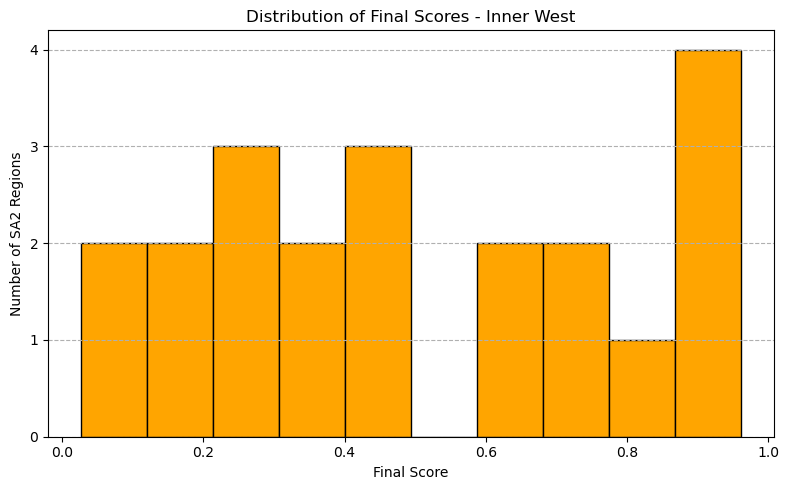

In [144]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Bar chart: top 10 regions
plt.figure(figsize=(8, 5))
plt.hist(final_scores["real_score"], bins=10, color="orange", edgecolor="black")
plt.title("Distribution of Final Scores - Inner West")
plt.xlabel("Final Score")
plt.ylabel("Number of SA2 Regions")
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid(axis="y", linestyle="--", )
plt.tight_layout()
plt.show()

# The resource distribution across Inner West is uneven.
# While some SA2 regions score highly, others lag significantly behind. 
#The spread of scores suggests that access to resources is not consistent across the region, 
#indicating noticeable variation rather than balance. 

### Top and Bottom Scoring Regions

The top 10 SA2 regions in the Inner West by real_score are led by **Concord – Mortlake – Cabarita**, **Five Dock – Abbotsford**, **Burwood (NSW)**, **Strathfield – West**, and **Drummoyne - Rodd Point**. These regions scored above 0.90, suggesting strong coverage in terms of public transport, schools, parks, libraries, and businesses in certain industry.

In contrast, **Ashfield - North** ranks among the lowest, with a real score close to **0.03**. 

### How Are the Scores Distributed?

Looking at the histogram of real scores, the results are kind of spread out — a bunch of regions scored really high, while a few ended up very low. This shows that the Inner West has a mix of both well-resourced and under-resourced areas, rather than being consistent across the board.

It’s also interesting how sharp the divide is — some regions are doing great in terms of access to public infrastructure, while others seem to be missing out.

### Why These Four Metrics?
We decided to use transport stops, schools, retail businesses (industry code G: Retail Trade), and parks as poi to calculate the final score of how well-resourced each SA2 area is. These four indicators were chosen because they are all basic and important services that almost every community needs, and they are also quite common across the three SA4 regions we are studying — City and Inner South, North Sydney and Hornsby, and Inner West.

Transport stops are important for daily travel. All three SA4 regions are well-developed and rely a lot on public transport. People need easy access to buses and trains to go to work, school, or shopping. So we think this is a fair metric to include in all areas.

Schools (per 1,000 people aged 5–19: starting from primary school's age) reflect access to education. In each region, there are families with kids, and having schools nearby is important for them. It also shows how prepared the area is for young population needs.

Retail businesses were counted using the number of businesses under industry code G (Retail Trade), which includes grocery stores, shopping centres, convenience shops, etc. These kinds of services are needed by almost everyone and are a good sign of commercial activity in an area. We chose this industry because it fits well with the lifestyle of the regions we study — all of them are relatively urban and mixed-use, with residents expecting shops nearby.

Parks are green spaces that give people a place to relax, exercise, and enjoy nature. In Sydney, people really care about open space, and many local councils also focus on maintaining good parks. We think this is a good way to reflect the quality of public space in the neighbourhood.

In conclusion, we chose these four features because they are relevant, balanced, and meaningful in most parts of the city. They also work well together and give a more complete view of what it’s like to live in each area — not only focusing on economy or education, but a mix of what people use in daily life.


### Component Breakdown

We investigate how each z-score component contributes to the total score.

In [ ]:
import seaborn as sns

# Correlation matrix between z components and real score
score_corr = final_scores[["z_stops", "z_schools", "z_libraries", "z_parks", "z_businesses", "real_score"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(score_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Components and Real Score")
plt.show()

### Correlation with Income

The project's rubric asks us to determine whether real score correlates with
median income in each region.

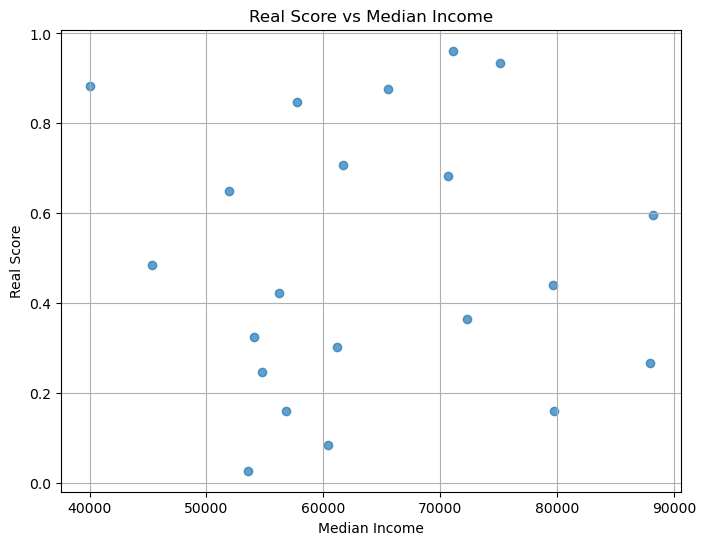

correlation coeffient: 1.801289224423109e-05


In [124]:
income = pd.read_csv("i_cleaned.csv")

final_scores["sa2_code21"] = final_scores["sa2_code21"].astype(str)
income["sa2_code"] = income["sa2_code"].astype(str)

income_joined = final_scores.merge(income, left_on="sa2_code21", right_on="sa2_code", how="left")

import matplotlib.pyplot as plt
# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(income_joined["median_income"], income_joined["real_score"], alpha=0.7)
plt.xlabel("Median Income")
plt.ylabel("Real Score")
plt.title("Real Score vs Median Income")
plt.grid(True)
plt.show()

# Correlation coefficient
income_corr = income_joined["real_score"].corr(income_joined["median_income"])
print("correlation coeffient:", income_corr)

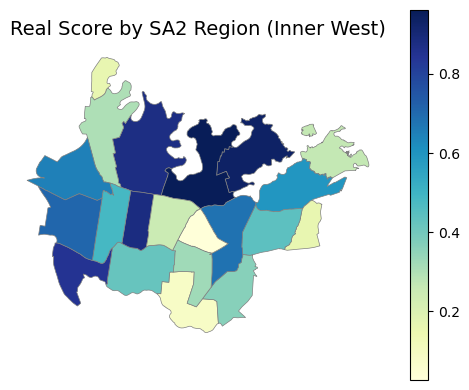

In [120]:
map_visual = innerwest_gdf.merge(final_scores, on="sa2_code21", how="left")
fig, ax = plt.subplots(figsize=(5, 4))
map_visual.plot(
    column="real_score",
    cmap="YlGnBu",
    linewidth=0.5,
    edgecolor="grey",
    legend=True,
    ax=ax
)
ax.set_title("Real Score by SA2 Region (Inner West)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

### Map Overlay: Real Score by Region

This map overlays the computed real scores on each SA2 region in the Inner West. The darker blue areas are the most well-resourced, based on our selected metrics (stops, schools, libraries, parks, and hospitality businesses). This kind of spatial visualization helps us see geographic patterns that are not obvious in tables — for example, which areas may need more infrastructure or investment.

In [116]:
final_scores_sorted = final_scores.sort_values("real_score", ascending=False).copy()
final_scores_sorted["Rank"] = range(1, len(final_scores_sorted) + 1)

top_bottom_table = pd.concat([
    final_scores_sorted.head(3),
    final_scores_sorted.tail(3)
])[["Rank", "sa2_name21", "real_score"]]

top_bottom_table["real_score"] = top_bottom_table["real_score"].round(2)

top_bottom_table.reset_index(drop=True, inplace=True)

top_bottom_table

,Rank,sa2_name21,real_score
0,1,Five Dock - Abbotsford,0.96
1,2,Drummoyne - Rodd Point,0.93
2,3,Burwood (NSW),0.88
3,19,Annandale (NSW),0.16
4,20,Canterbury (North) - Ashbury,0.08
5,21,Ashfield - North,0.03


In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

income = pd.read_csv("i_cleaned.csv")
final_scores["sa2_code21"] = final_scores["sa2_code21"].astype(str)
income["sa2_code"] = income["sa2_code"].astype(str)

merged = final_scores.merge(income, left_on="sa2_code21", right_on="sa2_code", how="left")
merged


,sa2_code21,sa2_name21,stops,schools,parks,businesses,z_stops,z_schools,z_parks,z_businesses,z_total,real_score,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,120031680,Strathfield - East,114,6.823821,29,7.598143,0.387941,0.338232,-0.776450,-0.009933,-0.060209,0.484952,120031680,Strathfield - East,12139,31,45329,68555
1,120021387,Balmain,74,2.822581,53,7.166165,-0.614738,-1.065259,0.860917,-0.195727,-1.014807,0.266040,120021387,Balmain,10567,47,87932,147434
2,120031393,Croydon Park - Enfield,114,5.275305,45,5.727705,0.387941,-0.204932,0.315128,-0.814413,-0.316276,0.421584,120031393,Croydon Park - Enfield,10065,44,56241,70223
3,120011386,Five Dock - Abbotsford,185,3.046923,64,8.619458,2.167696,-0.986568,1.611377,0.429338,3.221843,0.961648,120011386,Five Dock - Abbotsford,12751,45,71098,97098
4,120031576,Strathfield South,46,14.925373,24,9.868421,-1.316613,3.179966,-1.117568,0.966520,1.712305,0.847135,120031576,Strathfield South,2157,42,57764,73061
5,120031394,Dulwich Hill - Lewisham,90,8.267879,41,4.764807,-0.213666,0.844756,0.042234,-1.228558,-0.555235,0.364651,120031394,Dulwich Hill - Lewisham,11247,39,72319,87100
6,120031395,Haberfield - Summer Hill,111,9.302326,42,5.607615,0.312740,1.207603,0.110457,-0.866064,0.764736,0.682381,120031395,Haberfield - Summer Hill,8767,43,70670,103492
7,120031679,Croydon,94,6.193694,37,5.546967,-0.113398,0.117206,-0.230661,-0.892149,-1.119002,0.246196,120031679,Croydon,6661,43,54756,74209
8,120031678,Burwood (NSW),74,8.293020,30,13.397308,-0.614738,0.853575,-0.708226,2.484304,2.014915,0.882354,120031678,Burwood (NSW),9579,33,40000,57009
9,120011672,Concord West - North Strathfield,77,3.458712,54,6.730100,-0.539537,-0.842127,0.929141,-0.383280,-0.835804,0.302419,120011672,Concord West - North Strathfield,7939,41,61139,77778


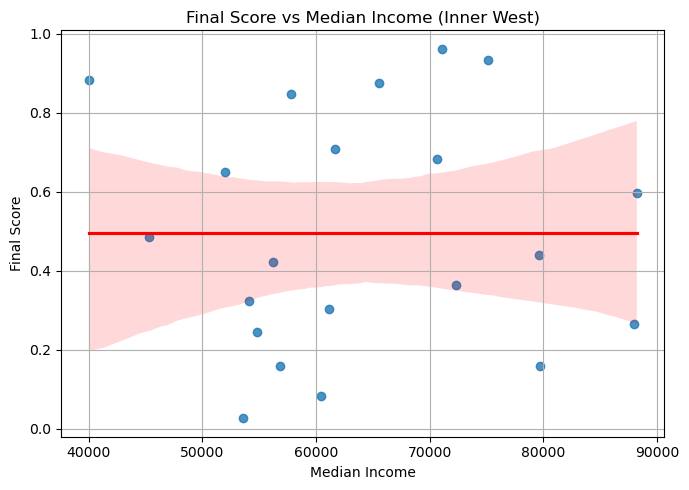

Correlation coefficient: 0.000018


In [142]:
corr_data = merged[["sa2_name21", "real_score", "median_income"]].dropna()

plt.figure(figsize=(7, 5))
sns.regplot(data=corr_data, x="median_income", y="real_score", line_kws={"color": "red"})
plt.title("Final Score vs Median Income (Inner West)")
plt.xlabel("Median Income")
plt.ylabel("Final Score")
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = merged["real_score"].corr(merged["median_income"])
print(f"Correlation coefficient: {correlation:.6f}")